<a href="https://colab.research.google.com/github/ellolo/llm-domain-adaptation-rag-lora/blob/main/notebooks/4_lora_combined_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lora combined training

In the previous notebooks (`2_lora_qa_finetuning.ipynb` and `3_lora_cont_pretraining.ipynb`) I experimented with two distinct approaches to teach a base model to answers user questions of a specific domain:

- In `2_lora_qa_finetuning.ipynb` I experimented with the classical Instruction Fine Tuning (ITF) approach: a base model is fine-tuned with a dataset of Question Answering pairs related to the domain, using [Low-Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685).

- In `3_lora_cont_pretraining.ipynb` I experimented with the less used Continued Pretraining approach: a base model is trained with the raw text extracted from domain documents (using Lora), similarly to how fundational models are typically pretrained.

For a quick intro on these two approaches have a look at [this paper](https://arxiv.org/pdf/2405.09673).

In this notebook, I experiment with a mixed approach: the training dataset consists of both the raw text (as in `3_lora_cont_pretraining.ipynb`), and a sample of 2,000 QA pairs from the dataset used in `2_lora_qa_finetuning.ipynb`.

The hope is that by training on a combined dataset we can get the best of both worlds. From the one side, the model has a good chance to truly and fully learn domain knowledge and domain jargon (Continued Pretraining). From the other side, the model retains the capability to answer questions on that domain (Instruction Fine Tuning).


As in the previous notebooks, I use `Llama-3.1-8B-Instruct` and `Llama-3.2-1B-Instruct` as base models, and the game of Chtulhu as domain.

## Stack
- [Hugging Face Transformers](https://huggingface.co/docs/transformers/en/index) to load and quantize the base models, and to perform fine-tuning
- [BitsAndBytes](https://huggingface.co/docs/bitsandbytes/main/en/index) for quantization.
- [Hugging Face Parameter-Efficient Fine-Tuning (PEFT)](https://huggingface.co/docs/peft/en/index) to configure the Lora model.
- [Hugging Face Hub](https://huggingface.co/docs/huggingface_hub/en/index) to store the Lora models checkpoints.

I recommend to use a machine with at least a **A100** Nvidia GPU. Although Lora is designed to save VRAM, a decent GPU is stil needed.

## Details
At a high-level, I do the following (more details are provided in the rest of the notebook):

1. Install dependencies and clone this github repo. I use the repo to read the Chtulhu Rulebook and the QA datasrt, and also to store performance data of the fine-tuning process.
2. Load the base model (either `Llama-3.1-8B-Instruct` or `Llama-3.2-1B-Instruct`) and quantize it to 4-bits to save VRAM. When quantized, these models are small enough to perform Lora fine-tuning on a A100 GPU.
3. Setup and configure the Lora model. This means that we create low-dimensional Lora adapters on top of specific layers of the base model, and fine-tune the weights of these adapters, leaving the weights of the original base model untouched, thus saving time and VRAM. I add Lora adapeters to all linear layers of the Llama models (both attention and FFN layers) including the head and the initial embedding. I set Lora rank to 64, Lora α to 32, and always activate rLora.
4. Prepare the dataset for training. The dataset consists of **chunks** of 256 tokens extracted from the Chtulhu Rulebook. More details are provided in the following sections.
5. Fine-tune the Lora model. I track the training loss as the main metric. I also track and store VRAM snapshots to monitor the memory usage.

# 1. Install dependencies and clone github repo

In [ ]:
%%capture
! pip install -U 'transformers[torch]' peft datasets bitsandbytes


In [ ]:
# get HF token from secrets and login in HF hub, so that we can download models from HF Hub

from huggingface_hub import login
from google.colab import userdata

HF_TOKEN=userdata.get('HF_TOKEN_WRITE')
if HF_TOKEN:
  login(HF_TOKEN, new_session=True)
else:
  login()

In [ ]:
# Clone github repository.

# Past here the SSH key stored on my personal laptopat: ~/dev/llm_cthulhu_fine_tuning/keys
# This is not safe, but unfortunaly using Colab secrets did not work.

! mkdir -p /root/.ssh
with open("/root/.ssh/id_rsa", mode="w") as fp:
    fp.write("""<YOUR SSH KEY TO THE REPO>""")

# <COPY FROM LOCAL DISK AT: ~/dev/llm_cthulhu_fine_tuning/keys>
! ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
! chmod go-rwx /root/.ssh/id_rsa
! git clone git@github.com:ellolo/llm-domain-adaptation-rag-lora.git

# 2. Load quantized pretrained model

The process is the same as in `2_lora_qa_finetuning.ipynb` and `3_lora_cont_pretraining.ipynb`. Please refer to those notebooks for detail explanation of the steps performed.

I experimented with the following base models: `Llama-3.1-8B-Instruct` and  `Llama-3.2-1B-Instruct`. These models are small enough to be finetuned with LoRA on a A100 GPU.
The base model is loaded into the GPU with 4-bit BitsAndBytes quantization.  Using quantization saves GPU memory, which allowed me to run LoRA fine-tuning with a 8B model on a single A100 GPU.

In [ ]:
# Set base model

model_name = "meta-llama/Llama-3.1-8B-Instruct" # "meta-llama/Llama-3.2-1B-Instruct" # "meta-llama/Llama-3.2-1B"

In [ ]:
# Configure BitsAndBytes

import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # weights stored in 4 bits (saves memory)
    bnb_4bit_quant_type="nf4",             # format used for storing in 4 bits
    bnb_4bit_use_double_quant=True,        # double quantize (saves memory)
    bnb_4bit_compute_dtype=torch.bfloat16, # perform operations in 16bit instead of 32bit (speed up fine-tuning)
)

In [ ]:
# Load quantized model on GPU

from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training

SKIP_FLASH_ATTENTION=True

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

mem_start = torch.cuda.memory_allocated(device)

# check if we can use flash-attention
try:
  if torch.cuda.get_device_capability()[0] >= 8 and not SKIP_FLASH_ATTENTION:
      print("Using flash-attention")
      attn_implementation = "flash_attention_2"
      !pip install -U flash_attn
  else:
      print("Using native attention")
      attn_implementation = "eager"
except:
  print("Using native attention (no GPU found)")
  attn_implementation = "eager"
attn_implementation = "eager"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    attn_implementation=attn_implementation,
).to(device)
model = prepare_model_for_kbit_training(model)

mem_model_load = torch.cuda.memory_allocated(device)
mem_used_model = round((mem_model_load - mem_start) / 1024/1024/1024, 4)

print(f"Using device:{device}")
print(f"Memory used for original model (GB): {mem_used_model}")
print(model)

# 3. Setup LoRA model

The process is the same as in `3_lora_cont_pretraining.ipynb`. Please refer to that Notebook for further details.

I experimented with the following Llora hyperparameter setups:
- **r**: 64
- **α**: 32
- **rLlora**: active
- **layers with Llora**: all linear layers \\
In `3_lora_cont_pretraining.ipynb` I included also the `lm_head` and `embed_tokens` layers. However in this experiment I decided not to do that, as I assumed that including them would be disastrous when tuning on the QA pairs.
- **batch size**: 64

In [ ]:
# Set Lora hyperparameters

from peft import LoraConfig, get_peft_model

def get_linear_layers(model, exclude_lm_head = True):
    """
    Returns the short sematic name of all layers that are linear,
    (excluding the final head layer if needed).

    Args:
        model: HF model to get linear layers from.
        exclude_lm_head (boolean, optional): True if lm_head layer must be included
    Returns:
        list: List of linear layers of the model.
    """
    linear_layers = set()
    for name, module in model.named_modules():
      module_type = str(type(module))
      if "Linear" in module_type:
        linear_layers.add(name.split(".")[-1])
    if exclude_lm_head and 'lm_head' in linear_layers:
      linear_layers.remove("lm_head")
    return list(linear_layers)

INCLUDE_HEAD_AND_EMB = False  # decide if to include lm_nead and embed_tokens layers

if INCLUDE_HEAD_AND_EMB:
  layers_for_lora = get_linear_layers(model, exclude_lm_head=False)
  layers_for_lora.append("embed_tokens")
else:
  layers_for_lora = get_linear_layers(model, exclude_lm_head=True)

print(f"Linear for LoRA: {layers_for_lora}")

LORA_R = 64 # 16, 32, 64, 128, 256
LORA_ALPHA = 32

lora_config = LoraConfig(
    r=LORA_R,                                 # rank (dim) of the adapters A and B. Higher value means more parameters to train (more expressivity but also more mem). Increasing does not bring substantial increase in performance.
    lora_alpha=LORA_ALPHA,                    # magnitude of adapter in changing the orginal params (W' = W + alpha/r * (A*B)). Usually alpha=2*r. Typicall set between 4 and 64. High a leans more to the adapter, low a leans more on original weights. Should be bigger for smaller models.
    target_modules= layers_for_lora,          # to which layers to apply lora adapters. This is the param that influences performance the most. According to QLoRA paper should use adapters to all linear layers to match full finetuning accuracy
    lora_dropout=0.0,                         # setting to 0 allows faster training, but risks some overfitting
    bias="none",
    use_rslora=True,                          # stabilizes adapters. changes the Lora equation to: W' = W + alpha/SQRT(r) * (A*B), so that for large r, the Lora adapters still have a significant impact on W'
    task_type="CAUSAL_LM",
)


Linear for LoRA: ['v_proj', 'gate_proj', 'down_proj', 'o_proj', 'up_proj', 'q_proj', 'k_proj']


In [ ]:
# Add LoRA adapters to the selected layers of the base model's architecture.

from peft import PeftModelForCausalLM

model: PeftModelForCausalLM = get_peft_model(model, lora_config)

mem_lora_model_load = torch.cuda.memory_allocated(device)
mem_used_lora_model = round((mem_lora_model_load - mem_model_load) / 1024/1024/1024, 4)
print(f"Memory used for original model (GB): {mem_used_model}")
print(f"Memory used for LoRA model (GB): {mem_used_lora_model}")
print(model)
print("*"*20)
model.print_trainable_parameters()

# 4. Prepare dataset

I train the base model on a dataset which consist of the raw text dataset used in `3_lora_cont_pretraining.ipynb`, to which I appended 2,000 random QA pairs from the dataset used in `2_lora_qa_finetuning.ipynb`. Please refer to these two notebooks to get more details on the used datasets.

Specifically, I do the following:

1. Prepare the **raw text dataset**: load the Chtulhu Rulebook, tokenize it, create chunks (context length is set to 256, stride to 32).
2. Prepare the **QA dataset**:  load the dataset, apply chat template, tokenize it.
3. Shuffle QA dataset, select 2,000 random QA pairs, append them to the raw text dataset.
4. Initialize the Data Collator as in `3_lora_cont_pretraining.ipynb`.


In [ ]:
# load textual dataset

from datasets import load_dataset

%cd /content/cthulhu_fine_tuning

dataset_file = "data/output/cthulhu.txt"

dataset = load_dataset(
    "text",
    data_files = dataset_file,
    sample_by="document",
    split = "train")

print(f"dataset size: {len(dataset)}")
print(f"Number of chars: {len(dataset[0]['text'])}")

In [ ]:
# Tokenize and chunk textual dataset

from transformers import AutoTokenizer
from collections import defaultdict
import numpy as np


def tokenize(example):
  """
  Tokenizes the text in the 'text' field of a dataset example.

  Args:
      example (dict): A dictionary containing the text data in the 'text' key.

  Returns:
      dict: A dictionary containing the tokenized input IDs under the 'input_ids' key.
  """
  return tokenizer(example["text"])


def create_chunks(example, context_length, stride=1):
  """
  Splits tokenized input IDs into overlapping chunks.

  Args:
      example (dict): A dictionary containing the tokenized input IDs under the 'input_ids' key.
      context_length (int): The desired length of each chunk, in number of tokens.
      stride (int, optional): The number of tokens to shift for the start of the next chunk. Defaults to 1.

  Returns:
      dict: A dictionary containing a list of tokenized chunks under the 'input_ids' key
            and a list of chunk lengths under the 'length' key.
  """
  chunks = []
  lengths = []
  for i in range(0, len(example["input_ids"][0]) - context_length + 1, stride):
    chunk = example["input_ids"][0][i : i + context_length]
    chunks.append(chunk)
    lengths.append(len(chunk))
  return {"input_ids": chunks, "length": lengths}


CONTEXT_LENGTH = 256  # nuber of tokens in each chunk
STRIDE = 32 # start the next chunk STRIDE tokens later

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# tokenize whole document
dataset_tokenized = dataset.map(tokenize, batched=False, remove_columns=dataset.column_names)

# split document into chunks
dataset_chunked = dataset_tokenized.map(
    create_chunks,
    batched=True,
    remove_columns=dataset_tokenized.column_names,
    fn_kwargs={"context_length": CONTEXT_LENGTH, "stride": STRIDE})

# show dataset statistics
print(f"Number of tokens: {len(dataset_tokenized['input_ids'][0])}")
print(f"Number of chunks: {len(dataset_chunked)}")
lengths = dataset_chunked["length"]
d = defaultdict(int)
for l in lengths:
  d[l] += 1
print("Distribution of chunk lengths:")
for k, v in d.items():
  print(f"{k}: {v}")

In [ ]:
# shuffle textual dataset
generator = np.random.default_rng(seed=42)
dataset_chunked = dataset_chunked.shuffle(generator=generator)

In [ ]:
# Loads QA dataset

import glob
import json
from pathlib import Path
from datasets import Dataset

%cd /content/cthulhu_fine_tuning


def generate_examples(dir: str, tokenizer, last_index) -> str:
  """
  Generator function to load QA pairs from JSON files and format them into ChatML.

  Args:
      dir (str): The directory containing the JSON files.
      tokenizer: The tokenizer with an `apply_chat_template` method.
      last_index: The index of the last file to include in the dataset.

  Yields:
      dict: A dictionary containing 'file_index' and 'chatml' for each example,
      where 'file_index' is the index of the file the example is extracted from,
      and 'chatml' is the actual conversation in the chatML format of the specific
      LLM model.
  """
  fnames = glob.glob(f"{dir}/*.json")
  for fname in fnames:
    file_index = int(Path(fname).name.split("_")[1])
    with open(fname) as f:
      if last_index and file_index > last_index:
        print(f"Skipping file: {fname}")
        continue
      for line in f:
        messages = json.loads(line)["messages"]
        chatml = tokenizer.apply_chat_template( # will fail if the model is not an instruct model
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        yield {"file_index":file_index, "chatml": chatml}

DATASET_LAST_FILE_INDEX=None
dataset_qa_path = "data/final_cleaned"

dataset_qa = Dataset.from_generator(
    generate_examples,
    gen_kwargs={
        "dir": dataset_qa_path,
        "tokenizer": tokenizer,
        "last_index": DATASET_LAST_FILE_INDEX
        },
    split="train"
    )

# print first QA pair of the training dataset in internal ChatML format
print(dataset_qa[0])

In [ ]:
# Tokenize QA dataset

from itertools import compress
from transformers import AutoTokenizer, AutoModelForCausalLM


def tokenize(dataset, tokenizer: AutoTokenizer):
  """
  Tokenizes the dataset using the provided tokenizer.

  Args:
      dataset: The dataset to tokenize.
      tokenizer (AutoTokenizer): The tokenizer to use.

  Returns:
      dict: A dictionary containing the tokenized data.
  """
  return tokenizer(
      dataset["chatml"],
      padding=False, # padding will be done by the DataCollector
      truncation=True,
      )

# max length of the context that we allow (keeps mem in check)
MAX_SEQ_LENGTH = CONTEXT_LENGTH

# tokenize
dataset_qa_tokenized = dataset_qa.map(
    tokenize,
    remove_columns=["file_index", "chatml"],
    batched=True,
    fn_kwargs={"tokenizer": tokenizer},
  )

# remove examples that are too long
dataset_qa_tokenized = dataset_qa_tokenized.filter(lambda x: len(x["input_ids"]) <= MAX_SEQ_LENGTH)


print(f"\n{dataset_qa_tokenized}")
print("*"*20)
print("tokenized example:")
print(dataset_qa_tokenized[0])
print("*"*20)
print("decoded tokenized example:")
print(tokenizer.decode(dataset_qa_tokenized[0]["input_ids"]))
print("*"*20)
print("Decoded tokenized example (only tokens that are not masked):")
print(tokenizer.decode(list(compress(dataset_qa_tokenized[0]["input_ids"], dataset_qa_tokenized[0]["attention_mask"]))))

In [ ]:
# shuffle QA dataset, select 2000 QA pairs, and merge it at the end of the textual dataset

QA_SAMPLE_SIZE = 2000

# shuffle dataset
generator = np.random.default_rng(seed=42)
dataset_qa_tokenized = dataset_qa_tokenized.shuffle(generator=generator)

# select only 300 random examples
dataset_qa_tokenized_sub = dataset_qa_tokenized.select(range(QA_SAMPLE_SIZE))

# add length column, remove attention_mark column
dataset_qa_tokenized_sub = dataset_qa_tokenized_sub.add_column("length", [len(ex["input_ids"]) for ex in dataset_qa_tokenized_sub])
dataset_qa_tokenized_sub = dataset_qa_tokenized_sub.remove_columns("attention_mask")

# concatenate datasets
from datasets import concatenate_datasets
dataset_combo = concatenate_datasets([dataset_chunked, dataset_qa_tokenized_sub])

In [ ]:
print(dataset_chunked)
print(dataset_qa_tokenized)
print(dataset_qa_tokenized_sub)
print(dataset_combo)

Dataset({
    features: ['input_ids', 'length'],
    num_rows: 14557
})
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 11927
})
Dataset({
    features: ['input_ids', 'length'],
    num_rows: 2000
})
Dataset({
    features: ['input_ids', 'length'],
    num_rows: 16557
})


<BarContainer object of 57 artists>

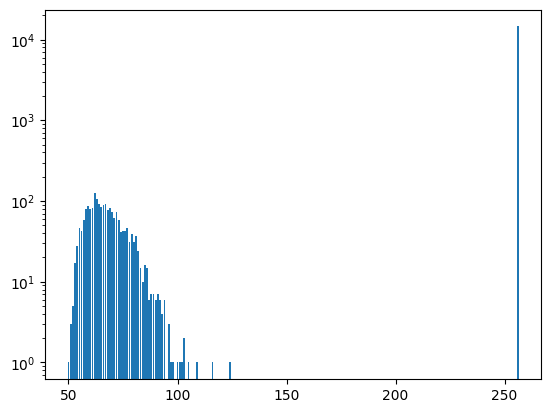

In [ ]:
# get distribution of context length across the dataset

from collections import defaultdict
from matplotlib import pyplot as plt


context_lengths = defaultdict(int)
for example in dataset_combo:
  context_lengths[example["length"]] += 1

display(plt.bar(context_lengths.keys(), context_lengths.values(), log=True))

In [ ]:
# set pad token for Llama tokenizer

tokenizer.add_special_tokens({"pad_token": "<|finetune_right_pad_id|>"})
model.config.pad_token_id = tokenizer.pad_token_id
tokenizer.padding_side = 'right'

print("*"*40)
print(f"Tokenizer vocab size before adding pad token: {len(tokenizer)}")
print(f"Tokenizer vocab size after adding pad token: {len(tokenizer)}")
print('Tokenizer pad token:', tokenizer.pad_token)
print('Tokenizer pad token id:', tokenizer.pad_token_id)
print('Model pad token id:', model.config.pad_token_id)
print("*"*40)


# inizialize data collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

****************************************
Tokenizer vocab size before adding pad token: 128256
Tokenizer vocab size after adding pad token: 128256
Tokenizer pad token: <|finetune_right_pad_id|>
Tokenizer pad token id: 128004
Model pad token id: 128004
****************************************


In [ ]:
# Let's check that the data collator produces output as we expect

import torch

dataloader = torch.utils.data.DataLoader(
    dataset_combo,
    collate_fn=data_collator,
    batch_size=2
    )

def occurrence_token_id(tensor, token_id):
  mask = token_id == tensor
  return mask.sum().item()

l = len(dataloader)
for ct, batch in enumerate(dataloader):
      if ct < 2 or (ct >= l-3 and ct < l-1):
        print()
        print(f"Sequences length: {len(batch['input_ids'][0])}")
        print(f"Padding tokens in sequence 1: {occurrence_token_id(batch['input_ids'][0], tokenizer.pad_token_id)}")
        print(f"Padding tokens in sequence 2: {occurrence_token_id(batch['input_ids'][1], tokenizer.pad_token_id)}")
        print(f"Sequence 1 decoded:\n {tokenizer.decode(batch['input_ids'][0])}")
        print(f"\nSequence 2 decoded:\n {tokenizer.decode(batch['input_ids'][1])}")
        print(f"Actual input to Trainer:")
        print(batch)
        print("*"*50)


# 5. Execute combined training

The process for training the model is exactly the same as in `3_lora_cont_pretraining.ipynb`. Please refer to that notebook for a detailed explanation of the training steps.

At a high level, I did the following:

1. Set fine-tuning parameters: **Learning rate** set to 1e-4 (I did not  include the `lm_head` and `embed_tokens` layers in these experiments). I used a simple Linear Scheduler [6], which warms up the learning rate until `warmup_ratio` steps, then linearly decreases it. **Epochs**: I set this to 1, i.e. each chunk of the text is seem once by the trainer. **Batch size**: I set the batch size as big as possible based on VRAM availability, i.e. to 64.

2. Setup logic for storing training loss and learning rate schedule into local log file. \\

3. Execute fine-tuning.

4. Save the following:
  - to Hugging Face Hub => best model and last checkpoint model. I use my personal HF namespace `mpenna77`
  - to Github => PyTorch memory profiling files [12] and training loss/learning rate schedule

In [ ]:
from pathlib import Path
from huggingface_hub import HfApi

# set hyperparameters
LR = 1e-4
LOW_LR = 5e-5
BATCH_SIZE = 32 # 16
NUM_SAVES = 5   # how many checkpoints to save

# setting run name
if INCLUDE_HEAD_AND_EMB:
  run_name = f"{model_name.split('/')[-1]}-lr{LR}-b{BATCH_SIZE}-r{LORA_R}-a{LORA_ALPHA}-combo-lora-cthulhu"
else:
  run_name = f"{model_name.split('/')[-1]}-lr{LR}-b{BATCH_SIZE}-r{LORA_R}-a{LORA_ALPHA}-combo-no_head-lora-cthulhu"
print(run_name)

# creating output directories
%cd /content/cthulhu_fine_tuning

out_dir = f"fine-tuning/models/{run_name}"           # temp local dir where checkpoints are saved
profiling_dir = f"fine-tuning/profiling/{run_name}"  # local dir where logs and mem profile are stored. will be pushed to github
log_file=f"{profiling_dir}/logs.txt"                 # log file storing for each log step various metrics
Path(out_dir).mkdir(exist_ok=True, parents=True)
Path(profiling_dir).mkdir(exist_ok=True, parents=True)


# Create HF repo for this model
api = HfApi(token=userdata.get('HF_TOKEN_WRITE'))
api.create_repo(repo_id=f"mpenna77/{run_name}", private=True, exist_ok=True)


In [ ]:
# setting learning rates separately for different layers.

from torch.optim.adamw import AdamW

params_low_lr = [
    "base_model.model.model.embed_tokens.lora_embedding_A.default",
    "base_model.model.model.embed_tokens.lora_embedding_B.default",
    "base_model.model.lm_head.lora_A.default.weight",
    "base_model.model.lm_head.lora_B.default.weight"
    ]

model_params = model.named_parameters()
grouped_parameters = [
    {'params': [p for n, p in model_params if not any(nd in n for nd in params_low_lr)], 'lr': LR},
    {'params': [p for n, p in model_params if any(nd in n for nd in params_low_lr)], 'lr': LOW_LR}
]

adam_optimizer = AdamW(grouped_parameters)

In [ ]:
# Insruct Trainer to log learning rates in local log file at every log event.

from transformers import TrainerCallback

class SaveLrCallback(TrainerCallback):
    """
    A TrainerCallback that logs learning rates to a local file at every log event.
    """
    def __init__(self, output_file):
        """
        Initializes the SaveLrCallback.

        Args:
            output_file (str): The path to the file where logs will be written.
        """
        super().__init__()
        self.output_file = output_file

    def on_log(self, args, state, control, logs=None, **kwargs):
      """
      Writes the logs to the output file at every log event.

      Args:
          args (TrainingArguments): The training arguments.
          state (TrainerState): The current state of the trainer.
          control (TrainerControl): The control object for the training loop.
          logs (Dict[str, float], optional): The logs to write. Defaults to None.
          **kwargs: Additional keyword arguments.

      Returns:
          TrainerControl: The control object for the training loop.
      """
      lr_scheduler = kwargs.pop("lr_scheduler")
      optimizer = kwargs.pop("optimizer")
      if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        for k, group in enumerate(optimizer.param_groups()):
          logs[f"lr_param_group_{k}"] = group["lr"]
      else:
        for k, v in enumerate(lr_scheduler.get_last_lr()):
          logs[f"lr_param_group_{k}"] = v
      print(logs)
      with open(self.output_file, "a") as f:
          f.write(str(logs) + "\n")
      return super().on_log(args, state, control, **kwargs)

In [ ]:
# define every how many steps we want to save checkpoints

num_examples = len(dataset_combo)
num_steps = num_examples // BATCH_SIZE
save_steps = num_steps // NUM_SAVES

print(f"Number of examples: {num_examples}")
print(f"Number of steps: {num_steps}")
print(f"save_steps: {save_steps}")

Number of examples: 16557
Number of steps: 517
save_steps: 103


In [ ]:
# Execute fine tuning

import time
from typing import Dict, Optional
import torch
from pathlib import Path
from transformers import TrainingArguments, Trainer, TrainerCallback, DataCollatorWithPadding
from transformers.integrations import flash_attention


training_args = TrainingArguments(
    output_dir=out_dir,
    gradient_accumulation_steps = 1,         # after how many steps (batches) to sum up the gradient and then update params
    lr_scheduler_type = "linear",            # learning rate is warmed up linearly until warmup_ratio steps, then linearly decreases
    warmup_ratio = 0.05,                     # firs x% of training steps will be used to slowly ramp-up learning rate (default is 0.1). Makes training more stable.
    weight_decay=0.3,                        # keep between 1.0 and 0.3
    per_device_train_batch_size=BATCH_SIZE,  # depends on VRAM availability
    num_train_epochs=1,                      # 3 should be sufficient. More could overfit and decrease creativity.
    save_strategy="steps",                   # set to "epoch" if storing checkpoints every epoch, or "step" if at every batch
    save_steps=save_steps,
    logging_steps=5,
    report_to="none",                        # Disable 'Weights and Biases' reporting
    label_names=["labels"],                  # see: https://github.com/unslothai/unsloth/issues/1788
    push_to_hub = True,
    hub_model_id = run_name,
    hub_strategy = "all_checkpoints",        # saves to the hub all checkpoints, including the last step
    hub_token = HF_TOKEN,
    #max_steps = 10,
)


time_start_training = time.perf_counter()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_combo,
    tokenizer=tokenizer,
    data_collator=data_collator,
    optimizers=(adam_optimizer, None) # the scheduler (set here to None) will be set automatically using the TrainingArguments (see: https://github.com/huggingface/transformers/blob/0725cd6953803b8aacfc85288cbfb83dea30c469/src/transformers/trainer.py#L1741)
)

# add callback to log learning rates
trainer.add_callback(SaveLrCallback(log_file))

# start capturing VRAM snapshots
torch.cuda.memory._record_memory_history(max_entries=100000)

results = trainer.train()

# end capturing VRAM snapshots
time_end_training = time.perf_counter()

# push tokenizer files to the hub
tokenizer.push_to_hub(run_name, private=True, token=HF_TOKEN)


In [ ]:
# Saving VRAM snapshots to Github

%cd /content/cthulhu_fine_tuning

profiling_file = f"{profiling_dir}/profile.pkl"
profiling_viz_file = f"{profiling_dir}/trace.html"

# saving memory profile file to local file system
Path(profiling_file).parent.mkdir(exist_ok=True, parents=True)
torch.cuda.memory._dump_snapshot(profiling_file)
torch.cuda.memory._record_memory_history(enabled=None)

# generating memory profile visualuzation files in local file system
! wget https://raw.githubusercontent.com/pytorch/pytorch/master/torch/cuda/_memory_viz.py
! python _memory_viz.py trace_plot {profiling_file} -o {profiling_viz_file}


# pushing profiling files to github
! git config --global user.email "marco.pennacchiotti@gmail.com"
! git add {profiling_dir}
! git commit -m "added new profiling files"
! git push origin main

## Reporting and post-analysis

In [ ]:
# Print VRAM memory usage

import torch

mem_training = torch.cuda.max_memory_allocated(device)
mem_used_training = round((mem_training - mem_lora_model_load) / 1024/1024/1024, 4)


print(f"training time: {(time_end_training - time_start_training):.1f} s")
print(f"Memory used for original model (GB): {mem_used_model}")
print(f"Memory used for LoRA model (GB): {mem_used_lora_model}")
print(f"Memory used for training (GB): {mem_used_training}")

training time: 11330.5 s
Memory used for original model (GB): 7.2716
Memory used for LoRA model (GB): 0.6265
Memory used for training (GB): 17.1418


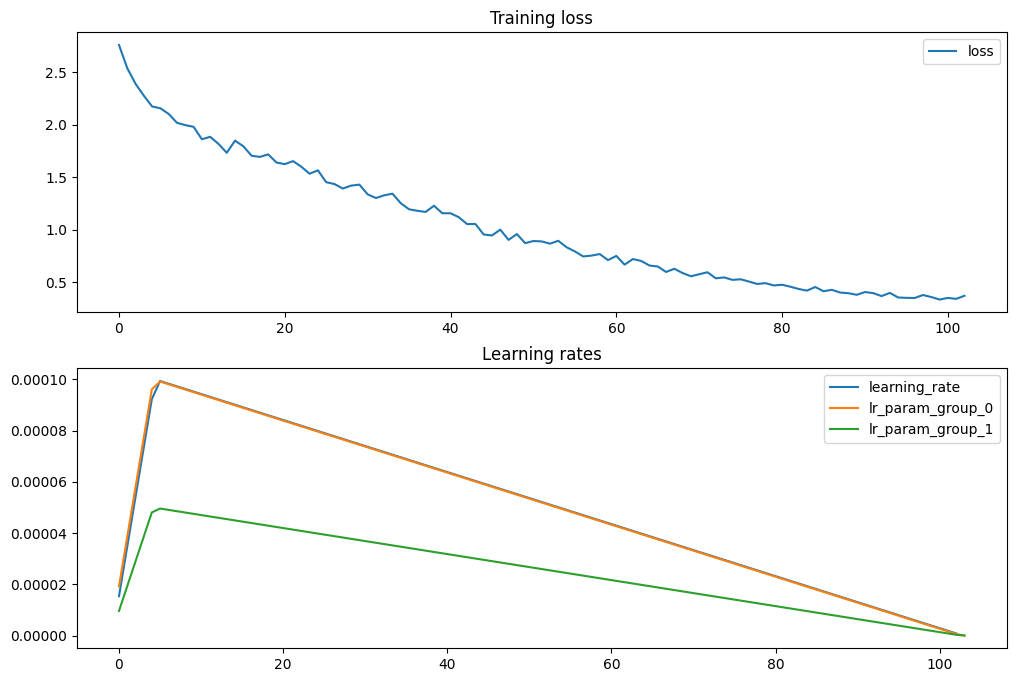

In [ ]:
# Plot training loss and learning rate schedule

import json
import pandas as pd
import matplotlib.pyplot as plt

log_data = []
with open(log_file, "r") as f:
  for ln in f:
    log_data.append(json.loads(ln.replace("'","\"")))

df = pd.DataFrame.from_dict(log_data)
fig, axs = plt.subplots(2, 1, figsize=(12,8))
df["loss"].plot(ax=axs[0])
df["learning_rate"].plot(ax=axs[1])
df["lr_param_group_0"].plot(ax=axs[1])
df["lr_param_group_1"].plot(ax=axs[1])
axs[0].legend()
axs[1].legend()
axs[0].set_title("Training loss")
axs[1].set_title("Learning rates")
plt.show()

# Utils to check GPU status

In [ ]:
## free the memory again
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

In [ ]:
! fuser -v /dev/nvidia*

In [ ]:
! sudo kill -9 293

In [ ]:
print(trainer.get_optimizer_cls_and_kwargs(training_args))
print(trainer.get)